In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

from Modules.SphericalM import *
from Modules.SphericalV import *
from Modules.SphericalC import *

import plotly.express as px

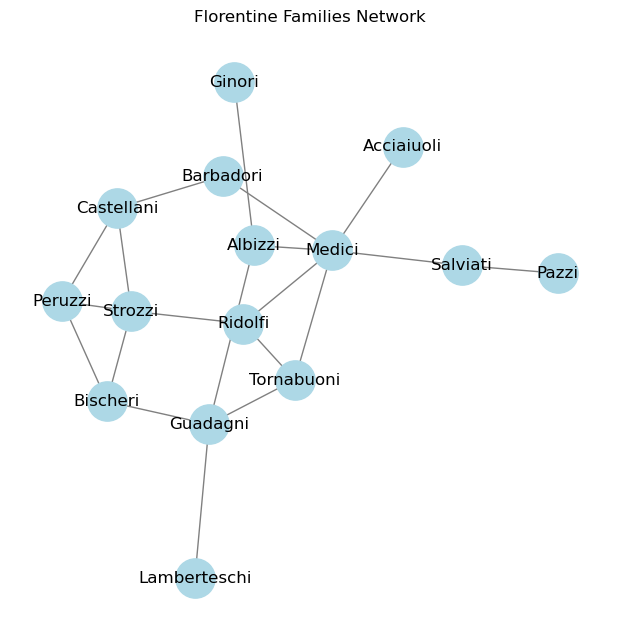

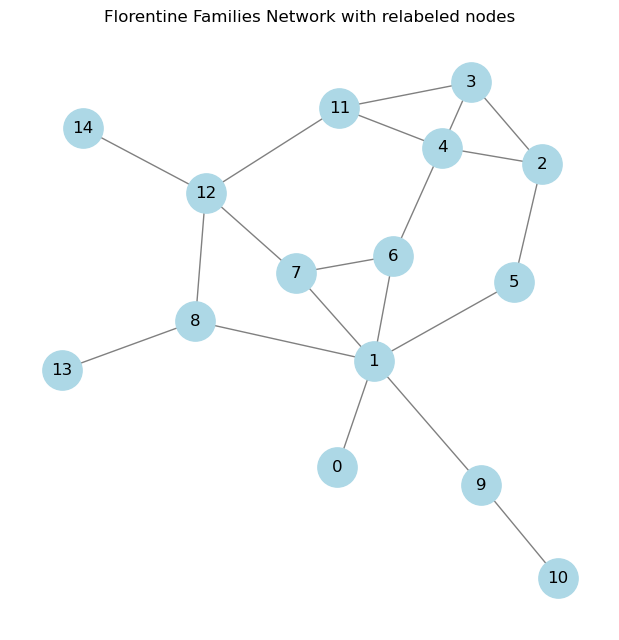

Map from original nodes to new nodes:
{'Acciaiuoli': 0, 'Medici': 1, 'Castellani': 2, 'Peruzzi': 3, 'Strozzi': 4, 'Barbadori': 5, 'Ridolfi': 6, 'Tornabuoni': 7, 'Albizzi': 8, 'Salviati': 9, 'Pazzi': 10, 'Bischeri': 11, 'Guadagni': 12, 'Ginori': 13, 'Lamberteschi': 14}


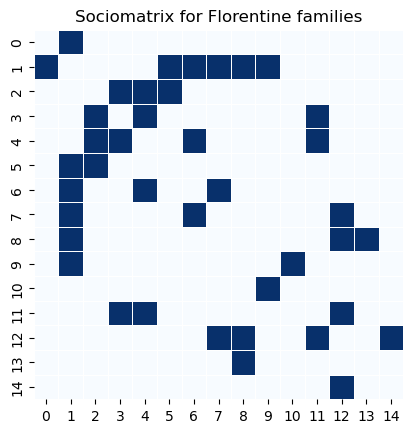

In [2]:
G = nx.florentine_families_graph()

plt.figure(figsize=(6,6))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=800)
plt.title("Florentine Families Network")
plt.show()

G = nx.florentine_families_graph()
node_mapping = {node: i for i, node in enumerate(G.nodes())}
G = nx.relabel_nodes(G, node_mapping)

plt.figure(figsize=(6,6))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=800)
plt.title("Florentine Families Network with relabeled nodes")
plt.show()
print("Map from original nodes to new nodes:")
print(node_mapping)

Y = nx.to_numpy_array(G, dtype=float)

sns.heatmap(Y, annot=False, cmap="Blues", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("Sociomatrix for Florentine families")
plt.show()

# Latent space

In [3]:
n = len(G.nodes)


inclination_angles_rand = np.pi*np.random.rand(n)
azimutal_angles_rand = 2*np.pi*np.random.rand(n)

x = np.sin(inclination_angles_rand) * np.cos(azimutal_angles_rand)
y = np.sin(inclination_angles_rand) * np.sin(azimutal_angles_rand)
z = np.cos(inclination_angles_rand)

Z_init_MLE = np.stack((np.sin(inclination_angles_rand) * np.cos(azimutal_angles_rand),
                       np.sin(inclination_angles_rand) * np.sin(azimutal_angles_rand),
                       np.cos(inclination_angles_rand)), axis=1)
a_init_MLE = np.random.randn()
b_init_MLE = np.random.randn()

df = pd.DataFrame(Z_init_MLE, columns=['x', 'y', 'z'])
df['node'] = df.index 
df['inclination_angle'] = inclination_angles_rand
df['azimutal_angle'] = azimutal_angles_rand

# Graficar
fig = px.scatter_3d(
    df,
    x='x',
    y='y',
    z='z',
    color_discrete_sequence=["blue"],  
    opacity=0.7,
    hover_data={
        'node': True,
        'inclination_angle': ':.2f',    
        'azimutal_angle': ':.2f',
        'x': ':.2f',
        'y': ':.2f',
        'z': ':.2f'
    }
)

fig.update_traces(marker=dict(size=4))
fig.update_layout(
    scene=dict(
        xaxis=dict(range=[-1, 1]),
        yaxis=dict(range=[-1, 1]),
        zaxis=dict(range=[-1, 1]),
        aspectmode='cube'
    ),
    title="Initialization of nodes in 3D space",
)

fig.show()

## Searching MLE

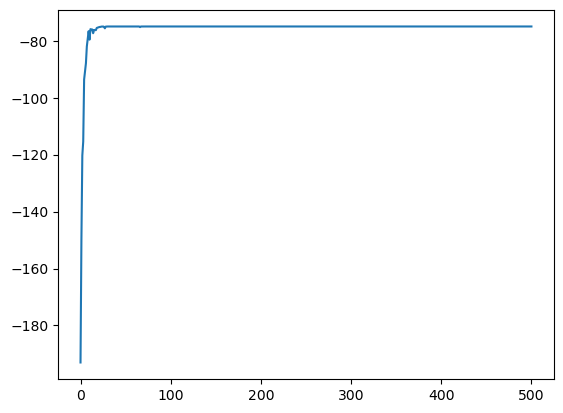

Initial log-likelihood: -193.02135866349667
Final log-likelihood: -74.95494101031245
Final alpha: -1.9995595687685197
Final beta: 3.040648309909455


In [4]:
Z_ML, a_ML,b_ML, historyZ, historya, historyb  =  SearchingMLE(G, Z_init_MLE ,a_init_MLE,b_init_MLE,500)
plt.plot([loglikelihood(G, historyZ[t],historya[t],historyb[t]) for t in range(len(historya))])
plt.show()

print("Initial log-likelihood:", loglikelihood(G,Z_init_MLE,a_init_MLE,b_init_MLE))
print("Final log-likelihood:", loglikelihood(G,Z_ML,a_ML,b_ML))
print("Final alpha:", a_ML)
print("Final beta:", b_ML)

In [5]:
df = pd.DataFrame(Z_ML, columns=['x', 'y', 'z'])
df['node'] = df.index 
fig = px.scatter_3d(
    df,
    x='x',
    y='y',
    z='z',
    color_discrete_sequence=["blue"], 
    opacity=0.7,
    hover_data={
        'node': True,
        'x': ':.2f',
        'y': ':.2f',
        'z': ':.2f'
    }
)

fig.update_traces(marker=dict(size=4))
fig.update_layout(
    scene=dict(
        xaxis=dict(range=[-1, 1]),
        yaxis=dict(range=[-1, 1]),
        zaxis=dict(range=[-1, 1]),
        aspectmode='cube'
    ),
    title="ML estimation of nodes S^2",
)

fig.show()

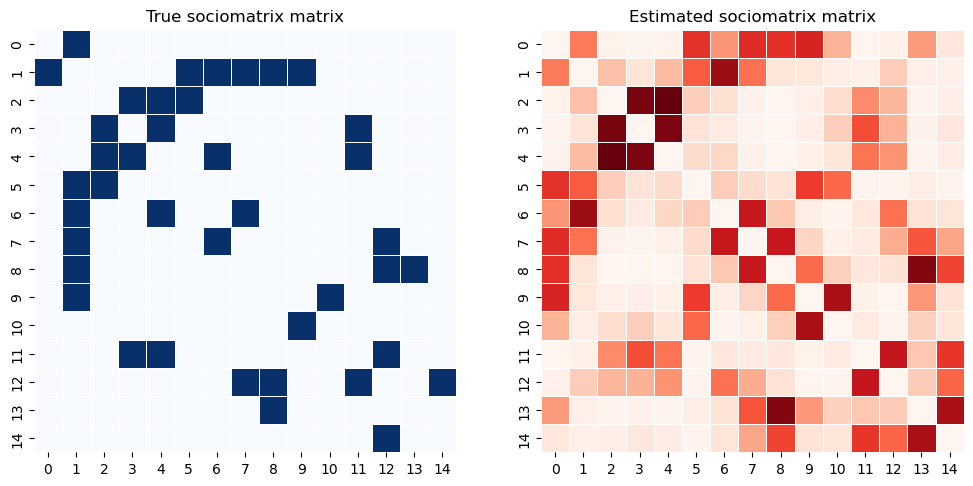

In [6]:
Y_ML = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if j != i:
            d = Z_ML[i].T @ Z_ML[j]
            Y_ML[i,j] = expit(a_ML + b_ML*d)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.heatmap(nx.to_numpy_array(G, dtype=int), annot=False, cmap="Blues", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("True sociomatrix matrix")
plt.subplot(1,2,2)
sns.heatmap(Y_ML, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("Estimated sociomatrix matrix")
plt.show()

## Applying Hamiltonian Monte Carlo Algorithm

In [27]:
# Execute HMC
number_of_samples = 10
Z_init = Z_ML.copy()
a_init = a_ML
b_init = b_ML


print("Log-L MLE:", loglikelihood(G,Z_ML,a_ML,b_ML))
print("Log-L starter:", loglikelihood(G,Z_init,a_init,b_init))

samples_Z, samples_a, samples_b, Hp, LogLp, acep_rate_history = ghmc(G, Z_init, a_init, b_init, number_of_samples, epsilon_init=0.1, 
                                                                     std_dev_init=0.2, std_dev_init_a = 1.0, std_dev_init_b = 0.5, 
                                                                     percentage_warmup=0.2)
samples_Z = [compute_starS2(samples_Z[i],Z_ML) for i in range(len(samples_Z))]
samples_Z = np.array(samples_Z)


# Estimators
## CM
from scipy.stats import circmean
inclination_angles_CM = circmean(np.arccos(samples_Z[:,:,2]), high=np.pi, low=0,axis=0)
azimutal_angles_CM = circmean(np.arctan2(samples_Z[:, :, 1], samples_Z[:, :, 0]), high=2*np.pi, low=0,axis=0)
Z_CM = np.stack((np.sin(inclination_angles_CM) * np.cos(azimutal_angles_CM),
                       np.sin(inclination_angles_CM) * np.sin(azimutal_angles_CM),
                       np.cos(inclination_angles_CM)), axis=1)
a_CM = np.mean(samples_a, axis=0)
b_CM = np.mean(samples_b, axis=0)


## MAP
Z_MAP = samples_Z[np.argmin(Hp),:,:]
a_MAP = samples_a[np.argmin(Hp)]
b_MAP = samples_b[np.argmin(Hp)]


print("Log-L MAP:", loglikelihood(G,Z_MAP,a_MAP,b_MAP))
print("Log-L CM:", loglikelihood(G,Z_CM,a_CM,b_CM))

Log-L MLE: -74.95494101031245
Log-L starter: -74.95494101031245
Number of samples: 10
Number of parameters: 17
Number of iterations: 12
Number of warmup iterations: 2


 17%|█▋        | 2/12 [00:01<00:06,  1.52it/s]

Final parameters: epsilon=0.0990, L=10, std_dev=0.1980, std_dev_a=1.0000, std_dev_b=0.5000


100%|██████████| 12/12 [00:09<00:00,  1.20it/s]

Acceptance rate: 0.39216
Log-L MAP: -74.2719462861918
Log-L CM: -71.71277850077175


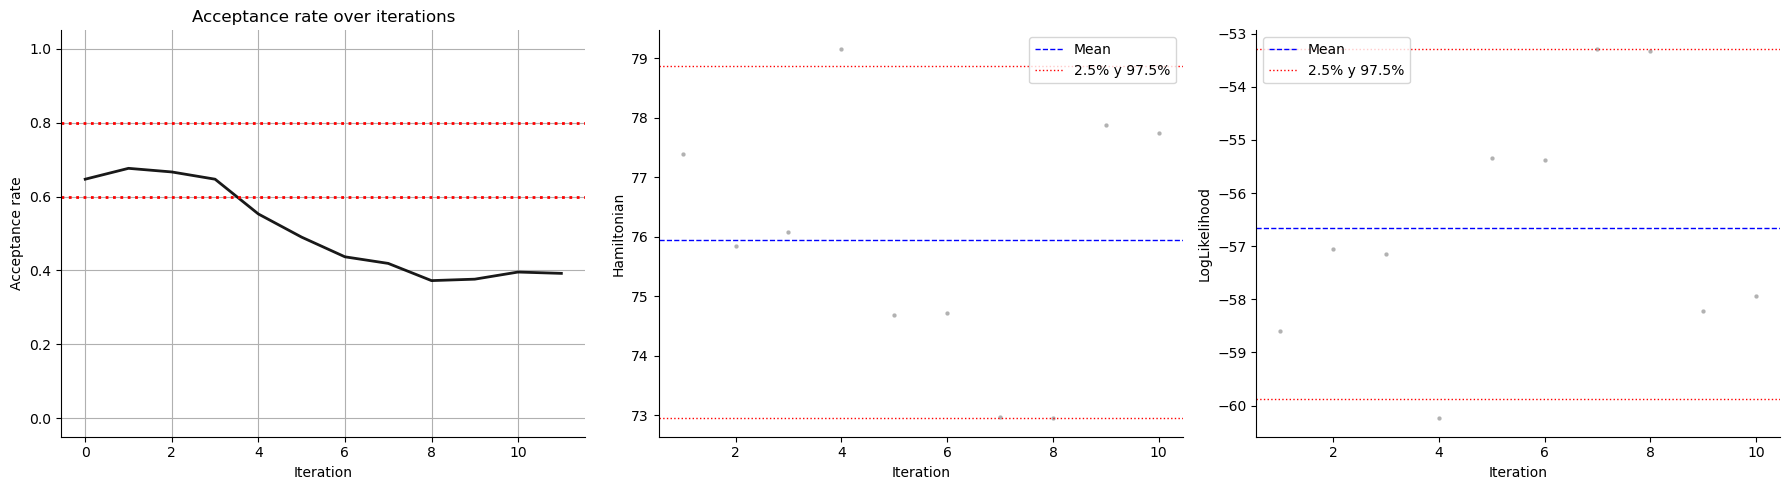

In [28]:
plot_diagnostics(Hp,LogLp,acep_rate_history)

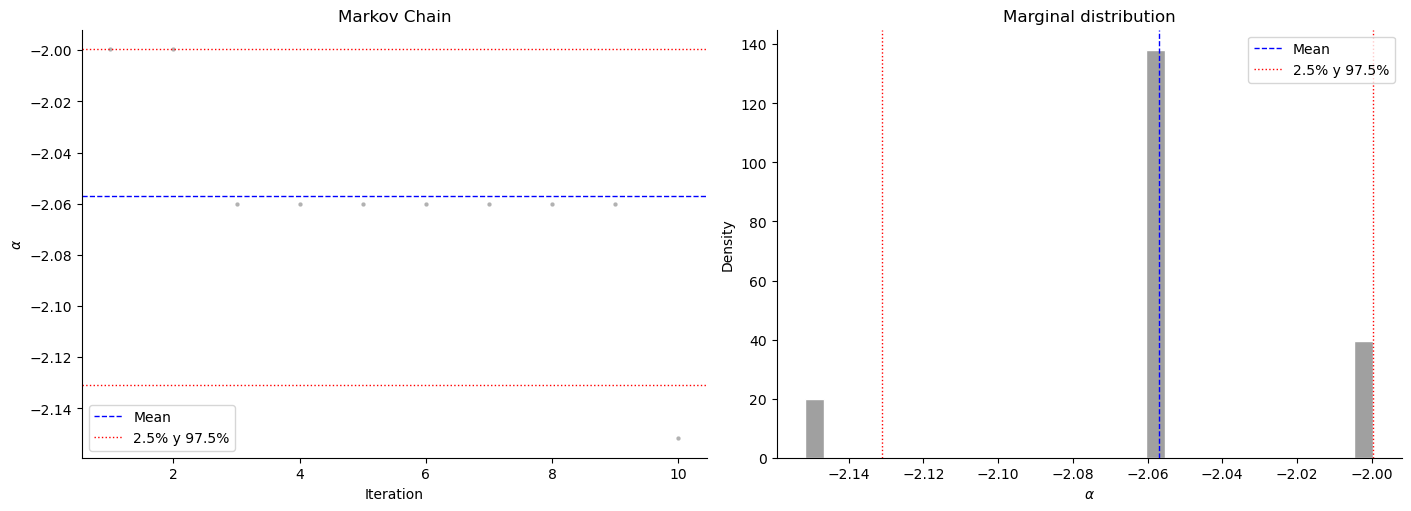

In [29]:
plot_alpha(samples_a)

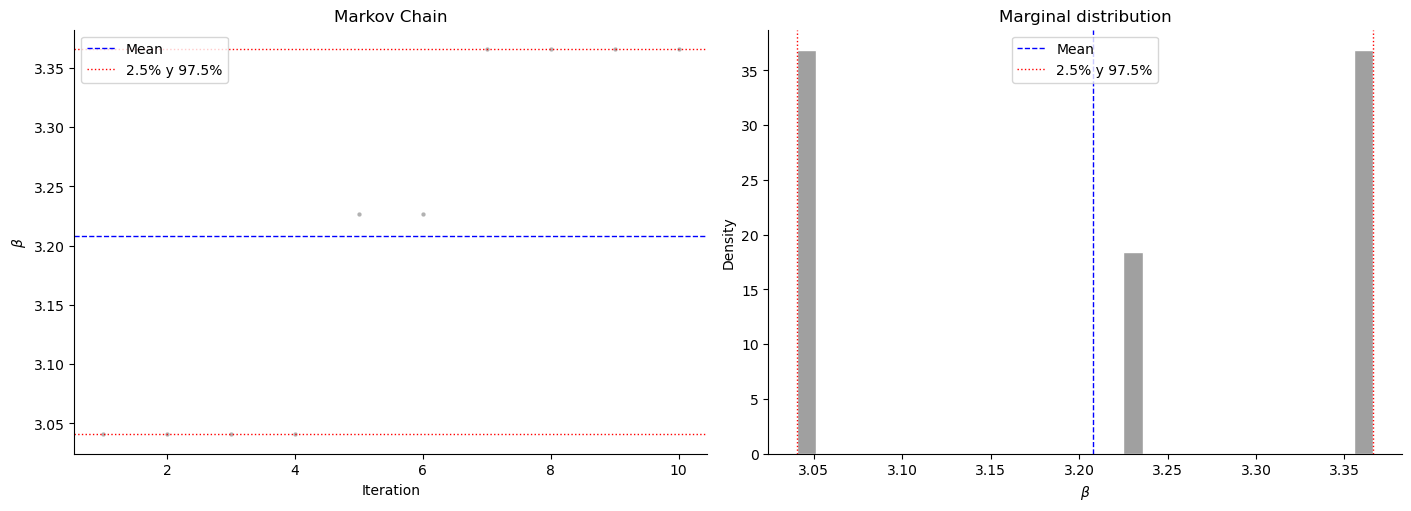

In [30]:
plot_beta(samples_b)

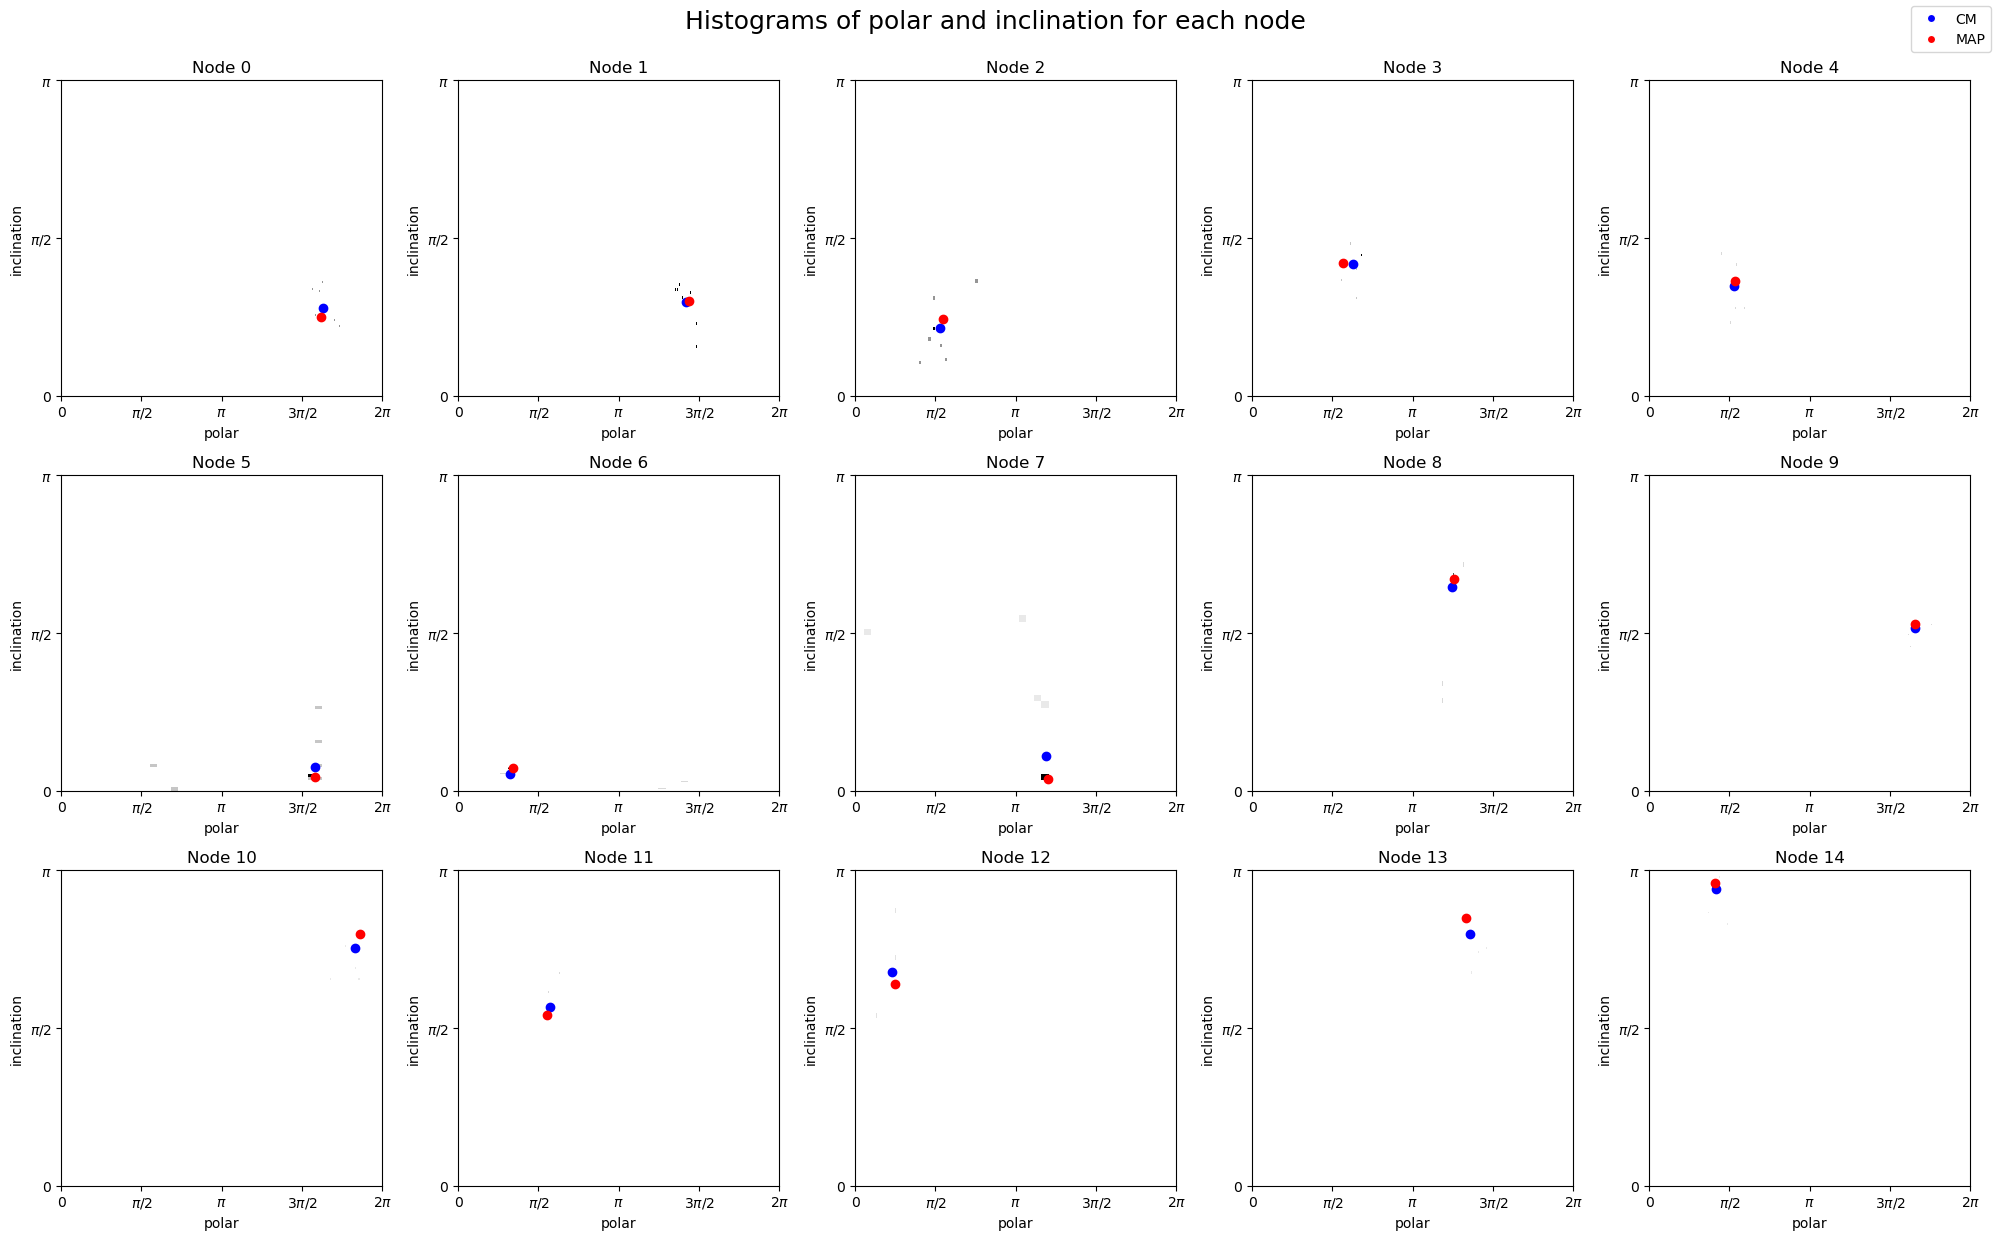

In [ ]:
fig, axes = plt.subplots(3, 5, figsize=(20, 12))  # Ajusta filas y columnas según # nodos
axes = axes.flatten()

for i in range(15):
    ax = axes[i]
    
    # Extraer muestras del nodo i (cada muestra es un punto en S^2)
    samples_i = samples_Z[:, i, :]  # (num_samples, 3)
    
    # Convertir a coordenadas esféricas
    phi = np.mod(np.arctan2(samples_i[:,1], samples_i[:,0]), 2*np.pi)   
    theta = np.mod(np.arccos(samples_i[:,2]), np.pi)  

    # Histograma 2D
    h = ax.hist2d(phi, theta, bins=(25, 25), cmap='Greys')

    # Coordenadas de MAP y CM
    phi_cm = np.mod(np.arctan2(Z_CM[i,1], Z_CM[i,0]), 2*np.pi)
    theta_cm = np.arccos(Z_CM[i,2])
    phi_map = np.mod(np.arctan2(Z_MAP[i,1], Z_MAP[i,0]), 2*np.pi)
    theta_map = np.arccos(Z_MAP[i,2])

    ax.plot(phi_cm, theta_cm, 'bo', label='CM')
    ax.plot(phi_map, theta_map, 'ro', label='MAP')
    
    ax.set_title(f'Node {i}')
    ax.set_xlabel(r'polar')
    ax.set_ylabel(r'inclination')
    ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
    ax.set_xticklabels(['0', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
    ax.set_yticks([0, np.pi/2, np.pi])
    ax.set_yticklabels(['0', r'$\pi/2$', r'$\pi$'])

# Leyenda común
handles = [plt.Line2D([0], [0], marker='o', color='w', label='CM', markerfacecolor='b'),
           plt.Line2D([0], [0], marker='o', color='w', label='MAP', markerfacecolor='r')]
fig.legend(handles=handles, loc='upper right')

plt.tight_layout()
plt.suptitle("Histograms of polar and inclination for each node", y=1.03, fontsize=18)
plt.show()


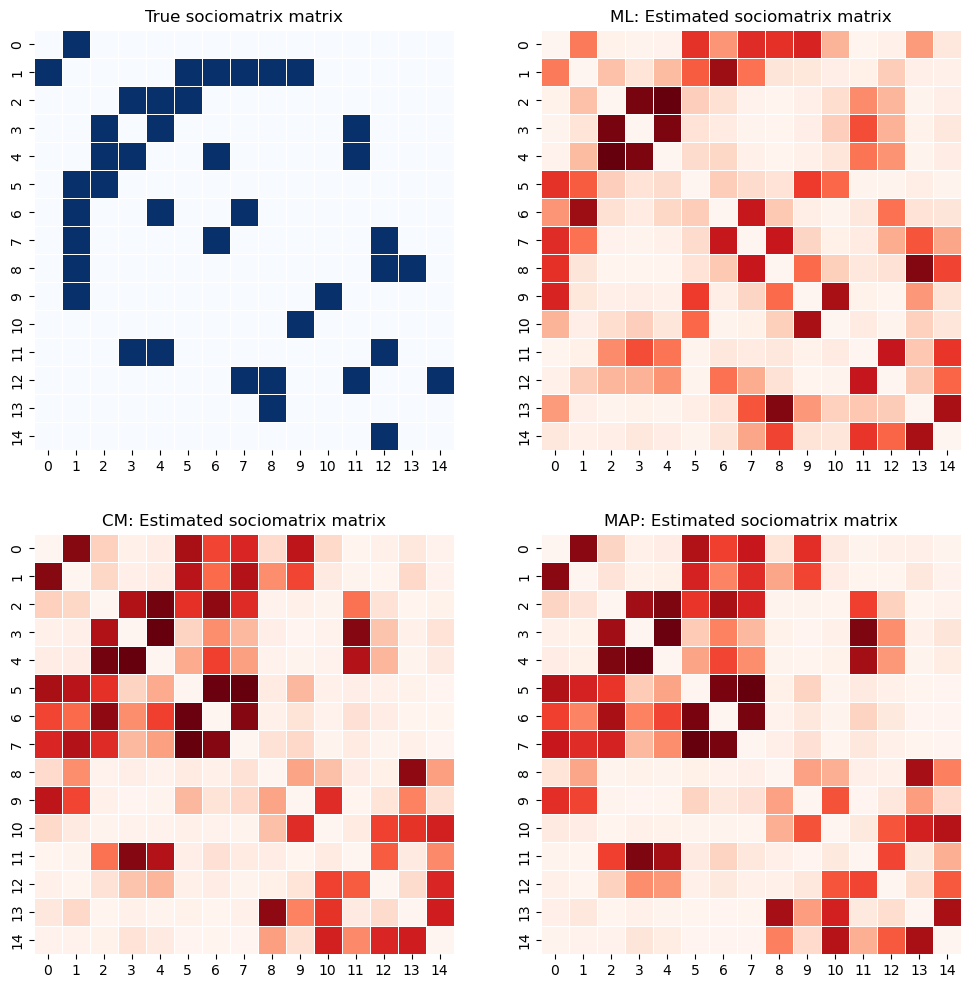

In [32]:
Y_CM = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if j != i:
            dist = Z_CM[i].T @ Z_CM[j]
            Y_CM[i,j] = expit(a_CM + b_CM * dist)

Y_MAP = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if j != i:
            dist = Z_MAP[i].T @ Z_MAP[j]
            Y_MAP[i,j] = expit(a_MAP + b_MAP * dist)

plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
sns.heatmap(Y, annot=False, cmap="Blues", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("True sociomatrix matrix")
plt.subplot(2,2,2)
sns.heatmap(Y_ML, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("ML: Estimated sociomatrix matrix")
plt.subplot(2,2,3)
sns.heatmap(Y_CM, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("CM: Estimated sociomatrix matrix")
plt.subplot(2,2,4)
sns.heatmap(Y_MAP, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("MAP: Estimated sociomatrix matrix")
plt.show()

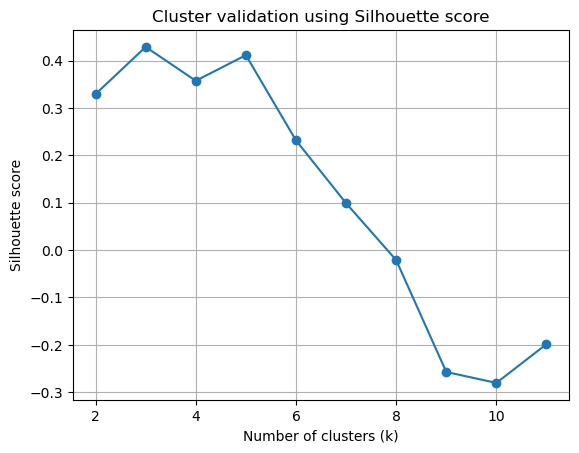

Best number of clusters: 3


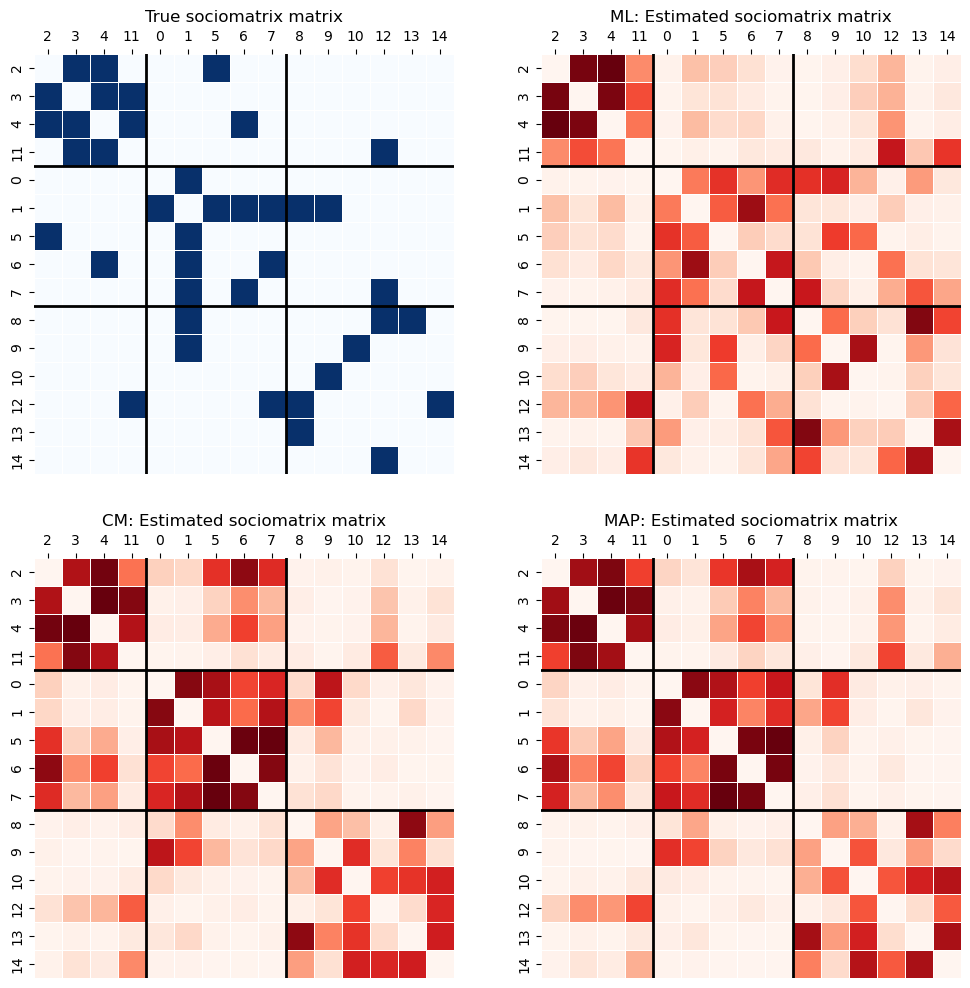

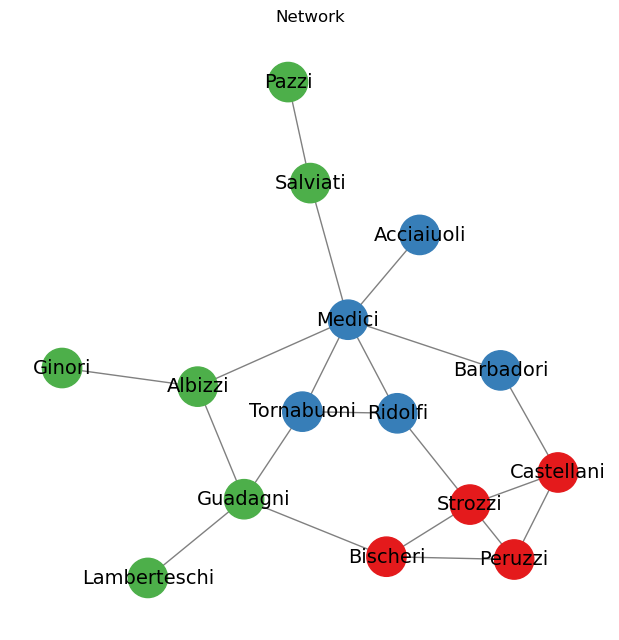

In [33]:
clusteringS2(G,node_mapping, Z_ML, a_ML, b_ML, Z_MAP, a_MAP, b_MAP, Z_CM, a_CM, b_CM)